In [20]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_io import load_excel_data, clean_observations, get_annual_summary
import plotting
plotting.setup_plotting_style() 

## Survey Protocol

This dataset follows a standardized breeding bird monitoring protocol:

- **Transect structure**: Each site contains **10 fixed observation points** arranged along a transect
- **Visit protocol**: Observers conduct **5-minute point counts** at each of the 10 points
- **Visitation frequency**: Each site is visited **at most twice** during the monitoring period
- **Detection recording**: All bird detections include species ID, count, and observer metadata

This standardized approach ensures comparable data across sites and years, though sampling effort varies (see below).

In [21]:
# load the data
data = load_excel_data('../data/raw/Observations 2012-2025.xlsx')
df_obs = data['observations']
df_species = data['species']
df_gps = data['gps']

Loading data from ../data/raw/Observations 2012-2025.xlsx
Loaded 86 species
Loaded 651 GPS points
Converting count columns to numeric
Loaded 114497 observation records


In [22]:
# take a look at the structure
print("Observations shape:", df_obs.shape)
print("\nColumn names:")
print(df_obs.columns.tolist())
print("\nFirst few rows:")
df_obs.head()

Observations shape: (114497, 28)

Column names:
['observer_name', 'department_code', 'transect_name', 'date', 'visit_number', 'cloud_cover_raw', 'rain', 'wind', 'visibility', 'point_number', 'start_time', 'species_name', 'distance_category_raw', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'count_auditory', 'count_visual_no_flight', 'count_audio_visual_no_flight', 'count_audio_visual_flight', 'notes', 'individual_count', 'year']

First few rows:


,observer_name,department_code,transect_name,date,visit_number,cloud_cover_raw,rain,wind,visibility,point_number,...,Unnamed: 18,Unnamed: 19,Unnamed: 20,count_auditory,count_visual_no_flight,count_audio_visual_no_flight,count_audio_visual_flight,notes,individual_count,year
0,nan,NaN,nan,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,> 100m,NaN,vol,NaN,NaN,NaN,NaN,nan,0.0,NaN
1,nan,NaN,nan,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,Auditif,Visuel,NaN,NaN,NaN,NaN,NaN,nan,0.0,NaN
2,BELFAN David,972.0,Fond l'Etang,2014-04-12,1.0,2,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,1.0,0.0,1.0,1.0,nan,3.0,2014.0
3,BELFAN David,972.0,Fond l'Etang,2014-04-12,1.0,2,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,0.0,1.0,1.0,1.0,nan,3.0,2014.0
4,BELFAN David,972.0,Fond l'Etang,2014-04-12,1.0,2,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,0.0,2.0,2.0,2.0,nan,6.0,2014.0


In [23]:
# clean it up
df_clean = clean_observations(df_obs)

Data Cleaning
Starting with 114497 records
⚠ Found 5 negative wind values - setting to NaN
Removed 4 records with zero/negative counts
Final dataset: 114493 records
  Years: 2014 - 2025
  Unique species: 102
  Unique transects: 72
  Unique observers: 42


In [24]:
# Data Quality Issues and Solutions
print("Critical Data Quality Issues")

print("1. Datetime encoding of counts")
print("   Problem: Count data was stored as datetime64 (Excel import artifact)")
print("   Solution: Extracted counts from nanosecond component of timestamps")
print("   Impact: Affected 100% of observations - now corrected\n")

print("2. Partial years")
print(f"   2014: {df_clean[df_clean.year == 2014]['date'].min().strftime('%B %d')} to {df_clean[df_clean.year == 2014]['date'].max().strftime('%B %d')} (partial)")
print(f"   2025: {df_clean[df_clean.year == 2025]['date'].min().strftime('%B %d')} to {df_clean[df_clean.year == 2025]['date'].max().strftime('%B %d')} (partial)")
print("   Recommendation: Focus analyses on complete years 2015-2024\n")

print("3. Observer effect")
top_observer = df_clean.groupby('observer_name').size().sort_values(ascending=False).iloc[0]
top_obs_name = df_clean.groupby('observer_name').size().sort_values(ascending=False).index[0]
obs_pct = (top_observer / len(df_clean)) * 100
print(f"   One observer ({top_obs_name}) conducted {obs_pct:.1f}% of all observations")
print("   Impact: Potential observer-specific detection biases\n")

print("4. Missing species metadata")
n_species_obs = df_clean['species_name'].nunique()
n_species_lookup = len(df_species)
print(f"   {n_species_obs} species observed, but only {n_species_lookup} in lookup table")
print(f"   {n_species_obs - n_species_lookup} species lack scientific names and migration status\n")

print("5. Distance bands")
print("   Distance sampling data is 70-99% missing")
print("   Analysis will focus on total counts only\n")

print("6. Negative wind values")
print(f"   Found {(df_obs['wind'] < 0).sum()} observations with negative wind values (data errors)")
print("   Solution: Set to NaN while retaining bird observations")


Critical Data Quality Issues
1. Datetime encoding of counts
   Problem: Count data was stored as datetime64 (Excel import artifact)
   Solution: Extracted counts from nanosecond component of timestamps
   Impact: Affected 100% of observations - now corrected

2. Partial years
   2014: March 29 to June 22 (partial)
   2025: April 01 to July 03 (partial)
   Recommendation: Focus analyses on complete years 2015-2024

3. Observer effect
   One observer (CONDE Beatriz) conducted 36.5% of all observations
   Impact: Potential observer-specific detection biases

4. Missing species metadata
   102 species observed, but only 86 in lookup table
   16 species lack scientific names and migration status

5. Distance bands
   Distance sampling data is 70-99% missing
   Analysis will focus on total counts only

6. Negative wind values
   Found 5 observations with negative wind values (data errors)
   Solution: Set to NaN while retaining bird observations


In [25]:
# get annual summary
annual_summary = get_annual_summary(df_clean)
annual_summary

,n_observations,n_species,total_abundance,n_transects,n_observers
year,,,,,
2014,5377,63,32643.000000,41,24
2015,8162,70,52453.000000,53,26
2016,11010,77,69062.000000,59,28
2017,9228,71,61685.380952,60,27
2018,9733,73,61208.000000,65,23
2019,9572,70,63217.000000,64,21
2020,9956,68,66171.000000,63,15
2021,10604,69,72048.000000,63,13
2022,10804,68,73549.000000,63,15


In [26]:
# Basic Dataset Overview
print("Basic Dataset Overview")

print("\nTemporal Coverage:")
print(f"  First observation: {df_clean['date'].min().strftime('%Y-%m-%d')}")
print(f"  Last observation:  {df_clean['date'].max().strftime('%Y-%m-%d')}")
print(f"  Total years:       {df_clean['year'].nunique()}")
print(f"  Year range:        {int(df_clean['year'].min())} - {int(df_clean['year'].max())}")

print("\nSpatial Coverage:")
print(f"  Unique transects:  {df_clean['transect_name'].nunique()}")
print(f"  Unique points:     {df_clean['point_number'].nunique()} (1-10 per transect)")

print("\nSpecies Diversity:")
print(f"  Unique species:    {df_clean['species_name'].nunique()}")
print(f"  Total individuals: {df_clean['individual_count'].sum():,.0f}")

print("\nSampling Effort:")
print(f"  Total observations: {len(df_clean):,}")
print(f"  Unique observers:   {df_clean['observer_name'].nunique()}")

print("\nCount Statistics:")
print(f"  Mean birds/observation:   {df_clean['individual_count'].mean():.1f}")
print(f"  Median birds/observation: {df_clean['individual_count'].median():.0f}")
print(f"  Max birds/observation:    {df_clean['individual_count'].max():.0f}")

Basic Dataset Overview

Temporal Coverage:
  First observation: 2014-03-29
  Last observation:  2025-07-03
  Total years:       12
  Year range:        2014 - 2025

Spatial Coverage:
  Unique transects:  72
  Unique points:     10 (1-10 per transect)

Species Diversity:
  Unique species:    102
  Total individuals: 747,639

Sampling Effort:
  Total observations: 114,493
  Unique observers:   42

Count Statistics:
  Mean birds/observation:   6.5
  Median birds/observation: 6
  Max birds/observation:    600


In [27]:
# Missing Value Analysis (Essential Columns Only)
print("Missing Value Analysis\n")

essential_cols = ['observer_name', 'transect_name', 'species_name', 'date', 
                  'year', 'individual_count', 'point_number', 'visit_number']

missing_summary = df_clean[essential_cols].isnull().sum()
missing_pct = (missing_summary / len(df_clean) * 100).round(2)

print("Essential columns:")
for col in essential_cols:
    if missing_summary[col] == 0:
        print(f"  {col:20s}: Complete")
    else:
        print(f"  {col:20s}: {missing_summary[col]:,} missing ({missing_pct[col]}%)")

print(f"\nWeather columns (wind, rain, visibility): <1% missing, so it's acceptable")
print(f"Distance bands columns: mostly missing , so will not use in analysis")
print(f"\nDataset quality is suitable for biodiversity analysis")

Missing Value Analysis

Essential columns:
  observer_name       : Complete
  transect_name       : Complete
  species_name        : Complete
  date                : Complete
  year                : Complete
  individual_count    : Complete
  point_number        : Complete
  visit_number        : Complete

Weather columns (wind, rain, visibility): <1% missing, so it's acceptable
Distance bands columns: mostly missing , so will not use in analysis

Dataset quality is suitable for biodiversity analysis


In [28]:
# Temporal Coverage Plot
annual_counts = df_clean.groupby('year').agg({
    'observation_id': 'count'
}).rename(columns={'observation_id': 'N_Obs'})

years = annual_counts.index.values
obs_counts = annual_counts['N_Obs'].values

# Identify partial years for highlighting
partial_years = [i for i, year in enumerate(years) if year in [2014, 2025]]

fig, ax = plotting.plot_bar_chart(
    x=years,
    y=obs_counts,
    xlabel='Year',
    ylabel='Number of Observations',
    title='Observation Effort Over Time',
    filename='../figures/eda_temporal_coverage.png',
    color=plotting.COLORS['primary'],
    highlight_indices=partial_years,
    highlight_color=plotting.COLORS['warning'],
    highlight_labels=['Partial\nYear'] * len(partial_years)
)
plt.show()
plt.close()  # Important: close after showing

/Users/olive1/Documents/Masters/T1/Applied Stats/Project/birds-biodiversity/notebooks/../src/plotting.py:97: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


✓ Saved: ../figures/eda_temporal_coverage.png


✓ Saved: ../figures/eda_spatial_coverage.png


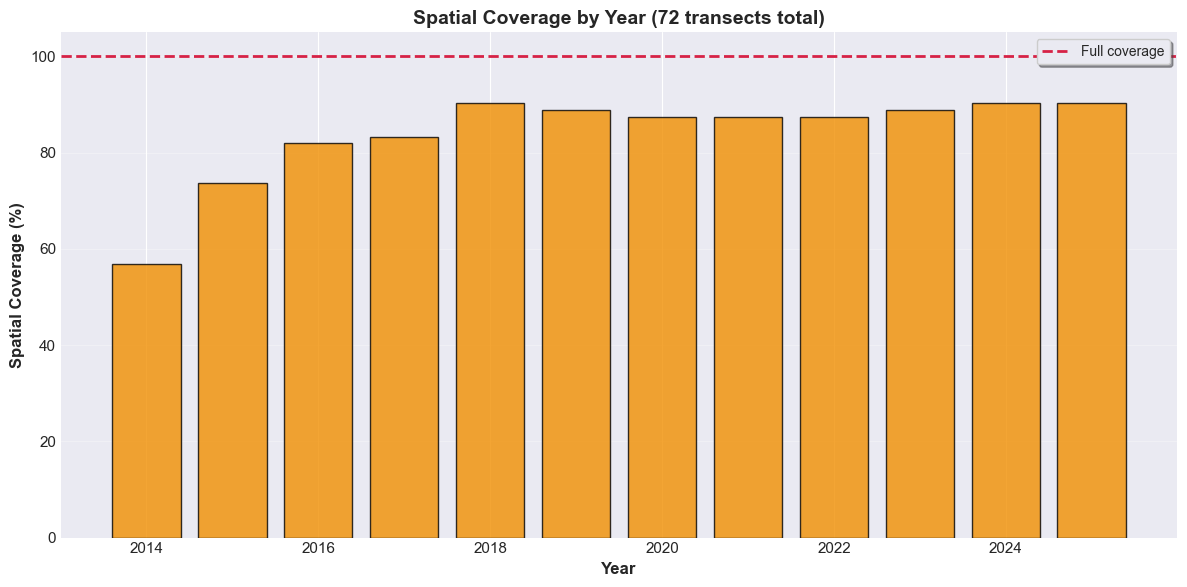

In [29]:
# Spatial Coverage Plot
transects_per_year = df_clean.groupby('year')['transect_name'].nunique()
total_transects = df_clean['transect_name'].nunique()
coverage_pct = (transects_per_year / total_transects * 100)

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(transects_per_year.index.astype(int), coverage_pct.values, 
       color=plotting.COLORS['accent'], edgecolor='black', alpha=0.8)
ax.axhline(y=100, color=plotting.COLORS['warning'], linestyle='--', 
           linewidth=2, label='Full coverage')
ax.set_xlabel('Year', fontweight='bold', fontsize=12)
ax.set_ylabel('Spatial Coverage (%)', fontweight='bold', fontsize=12)
ax.set_title(f'Spatial Coverage by Year ({total_transects} transects total)', 
             fontweight='bold', fontsize=14)
ax.legend(frameon=True, shadow=True)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()

# Save with robust method
import os
os.makedirs('../figures', exist_ok=True)
plt.savefig('../figures/eda_spatial_coverage.png', dpi=300, bbox_inches='tight', format='png')
print("✓ Saved: ../figures/eda_spatial_coverage.png")

plt.show()
plt.close()

### Species: simple summaries and plots

Below we summarise species-level totals and richness over time to understand which species dominate counts and how diversity changes annually.

✓ Saved: ../figures/eda_species_top20.png


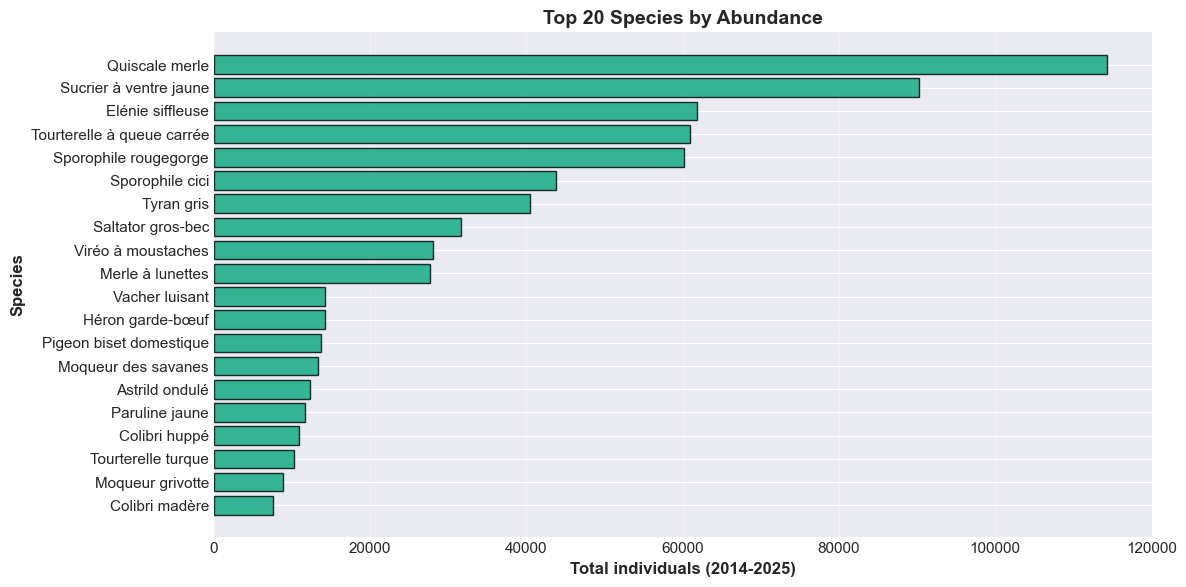

In [30]:
# Top 20 species by total individuals
species_totals = (
    df_clean.groupby('species_name')['individual_count']
            .sum()
            .sort_values(ascending=False)
)

top_n = 20
top_species = species_totals.head(top_n)

fig, ax = plotting.plot_bar_chart(
    x=top_species.index[::-1],
    y=top_species.values[::-1],
    xlabel='Total individuals (2014-2025)',
    ylabel='Species',
    title=f'Top {top_n} Species by Abundance',
    filename='../figures/eda_species_top20.png',
    color=plotting.COLORS['success'],
    horizontal=True
)
plt.show()
plt.close()

✓ Saved: ../figures/eda_species_richness_by_year.png


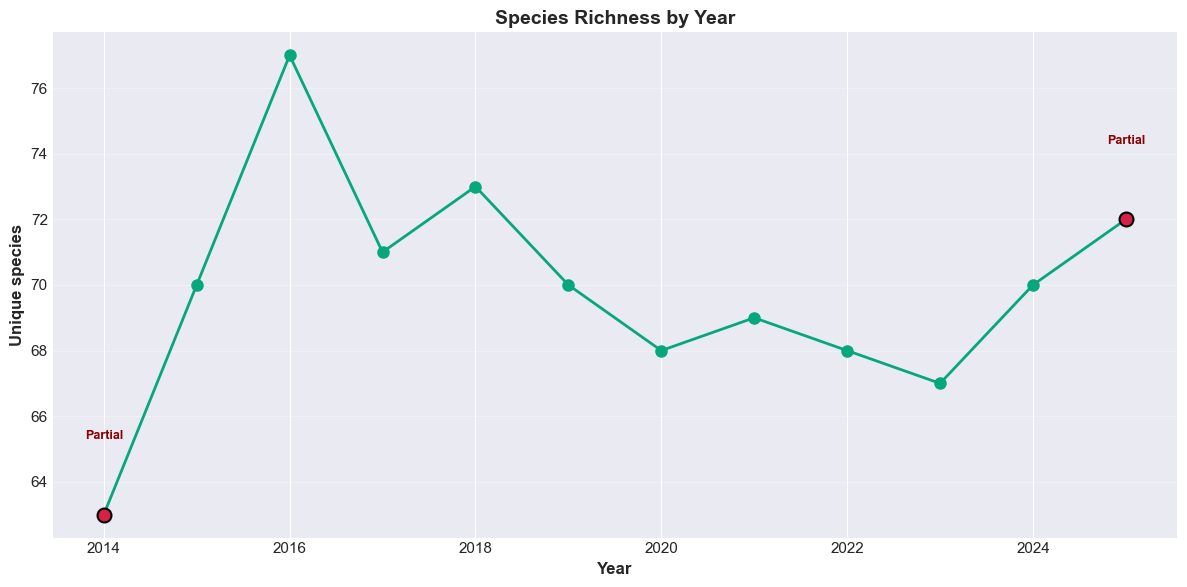

In [31]:
# Annual species richness
richness_by_year = (
    df_clean.groupby('year')['species_name']
            .nunique()
            .sort_index()
)

fig, ax = plotting.plot_line_chart(
    x=richness_by_year.index.values,
    y=richness_by_year.values,
    xlabel='Year',
    ylabel='Unique species',
    title='Species Richness by Year',
    filename='../figures/eda_species_richness_by_year.png',
    color=plotting.COLORS['success'],
    highlight_points=[2014, 2025],
    highlight_color=plotting.COLORS['warning'],
    highlight_labels=['Partial', 'Partial']
)
plt.show()
plt.close()

### Observer effort: simple summaries and plots

We assess how sampling effort is distributed across observers and over time.


✓ Saved: ../figures/eda_observer_effort.png


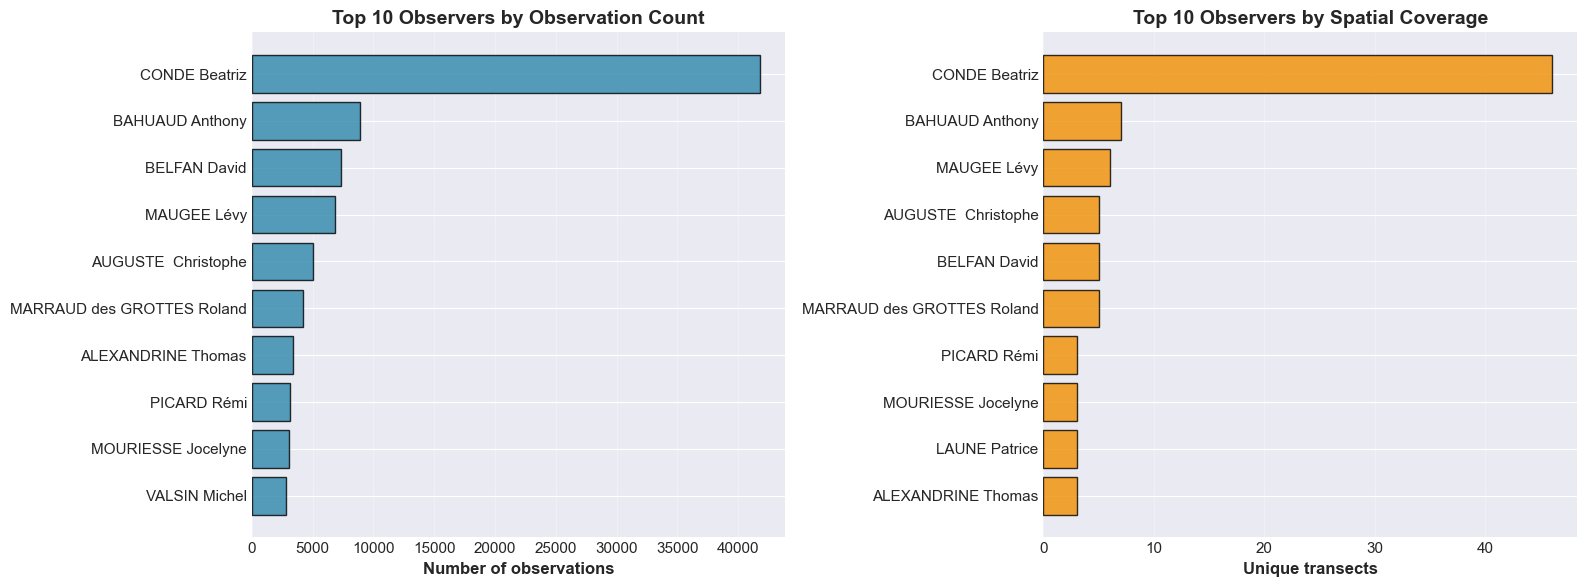

In [32]:
# Observer Effort Analysis
obs_by_observer = df_clean.groupby('observer_name').size().sort_values(ascending=False)
transects_by_observer = df_clean.groupby('observer_name')['transect_name'].nunique().sort_values(ascending=False)

n = 10
fig, axes = plotting.plot_dual_bars(
    data1=obs_by_observer.head(n).values[::-1],
    data2=transects_by_observer.head(n).values[::-1],
    labels1=obs_by_observer.head(n).index[::-1],
    labels2=transects_by_observer.head(n).index[::-1],
    title1=f'Top {n} Observers by Observation Count',
    title2=f'Top {n} Observers by Spatial Coverage',
    xlabel1='Number of observations',
    xlabel2='Unique transects',
    color1=plotting.COLORS['primary'],
    color2=plotting.COLORS['accent'],
    filename='../figures/eda_observer_effort.png'
)
plt.show()
plt.close()